In [1]:
#TODO: Normalize dataset labels, try 2 outputs

In [2]:
DATA_PATH = '../data'
TRAIN_DATA_PATH = f'{DATA_PATH}/train'
TASK_DATA_PATH = f'{DATA_PATH}/test'
TRAIN_FILENAME = f'{DATA_PATH}/train_gt.csv'
TASK_FILENAME = f'{DATA_PATH}/test.csv'

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

df = pd.read_csv(TRAIN_FILENAME, header=None, names=['audio', 'label'])
df['audio'] = TRAIN_DATA_PATH + "/" + df['audio']

x, y = df['audio'], df['label'].to_numpy().reshape(-1, 1)

weight_for_0 = (1 / (len(y) - np.sum(y))) * (len(y) / 2.0)
weight_for_1 = (1 / np.sum(y)) * (len(y) / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.7903573352486982, 1: 1.3610080395794681}


/opt/miniconda3/envs/mfcc-cnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#from rnnoise_wrapper import RNNoise
from pydub import AudioSegment
import python_speech_features as psf


def preprocess_function(audio_path):
    segment = AudioSegment.from_mp3(audio_path)

    inputs = psf.mfcc(
        np.array(segment.get_array_of_samples()), segment.frame_rate
    )

    return inputs.reshape(-1, 13)

In [5]:
# features_list = []

# for audio in tqdm(x):
#     features_list.append(preprocess_function(audio))

# #features_list = pad_each(features_list)

# #X = np.stack(features_list)

In [6]:
# np.save("train", X)

In [7]:
X = np.load('train.npy').astype(float)

In [8]:
normalize = np.max(X)
X /= normalize

In [9]:
import tensorflow as tf
# X = tf.keras.utils.pad_sequences(features_list, padding='post')

In [10]:
diff = len(y) - sum(y) - sum(y)

indexes = []

for ind, i in enumerate(y):
    if i == 0:
        diff -= 1
        indexes.append(ind)
        if diff == 0:
            break

In [11]:
X = np.delete(X, indexes, axis=0)
y = np.delete(y, indexes, axis=0)

In [12]:
X.shape, y.shape

((6468, 3955, 13), (6468, 1))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

print('Относительное количество положительный записей')
print(f'Вся выборка: {sum(y) / len(y)}')
print(f'Обучающая выборка: {sum(y_train) / len(y_train)}')
print(f'Валидационная выборка: {sum(y_test) / len(y_test)}')

Относительное количество положительный записей
Вся выборка: [0.5]
Обучающая выборка: [0.49745969]
Валидационная выборка: [0.50592478]


In [14]:
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, \
    LSTM, SimpleRNN, Conv2D, MaxPool2D, Masking, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model

In [15]:
class MyModel(Model):
    def __init__(self):
        super().__init__()
        self.conv = Sequential([
            #Embedding(input_dim=X.shape[1], output_dim=64, mask_zero=True),
            Conv1D(32, 3, activation='relu'),
            MaxPool1D(),
            Dropout(0.1),
            Conv1D(64, 3, activation='relu'),
            MaxPool1D(),
            Dropout(0.1),
            Flatten(),
            # Dense(10, activation='relu'),
        ])
        self.denses = Sequential([
            LSTM(64),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid'),
        ])

    def call(self, x):
        x = self.conv(x)
        x = tf.expand_dims(x, axis=1)
        x = self.denses(x)

        return x

model = MyModel()

# model.summary()

2024-08-11 13:00:06.630782: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-11 13:00:06.630803: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-11 13:00:06.630808: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-11 13:00:06.630821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-11 13:00:06.630835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.8)

custom_callbacks = [
    EarlyStopping(
        monitor='val_f1_score',
        min_delta=1e-5,
        patience=10,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    ),
    ModelCheckpoint(
        './saves/rnn_mfcc_checkpoints/checkpoint.weights.h5',
        monitor='val_f1_score',
        mode='max',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch'
    )
]

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy', tf.keras.metrics.F1Score(average='macro',
                                                  threshold=0.5)]
)

hist = model.fit(
    X_train, y_train,
    epochs=50,
    callbacks=custom_callbacks,
    verbose=1,
    validation_data=(X_test, y_test),
#    shuffle=True,
#    class_weight=class_weight
)

Epoch 1/50


/opt/miniconda3/envs/mfcc-cnn/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-08-11 13:00:08.232324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4949 - f1_score: 0.4738 - loss: 0.6951
Epoch 1: val_f1_score improved from -inf to 0.00808, saving model to ./saves/rnn_mfcc_checkpoints/checkpoint.weights.h5
142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.4949 - f1_score: 0.4738 - loss: 0.6951 - val_accuracy: 0.4941 - val_f1_score: 0.0081 - val_loss: 0.6931
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5244 - f1_score: 0.4661 - loss: 0.6913
Epoch 2: val_f1_score improved from 0.00808 to 0.20878, saving model to ./saves/rnn_mfcc_checkpoints/checkpoint.weights.h5
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.5245 - f1_score: 0.4663 - loss: 0.6913 - val_accuracy: 0.5080 - val_f1_score: 0.2088 - val_loss: 0.6908
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5700 - f1_score: 0.4702 - loss: 0.6747
Epoch 3: val_f1_score improved from 0.20878 to 0.34545, saving model to ./saves/rnn_mfcc_checkpoints/checkpoint.weights.h5
142

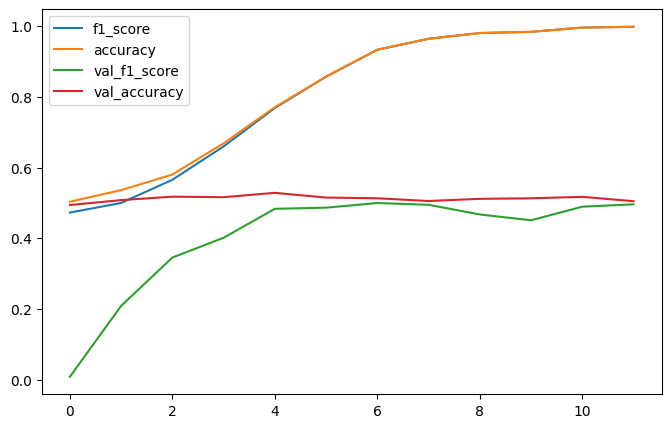

In [17]:
pd.DataFrame(hist.history)[['f1_score', 'accuracy', 'val_f1_score', 'val_accuracy']].plot(figsize=(8,5))
plt.show()

In [18]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 63168)          │         7,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │    16,193,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,604,229 (185.41 MB)

 Trainable params: 16,201,409 (61.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,402,820 (123.61 MB)

In [32]:
model.load_weights('./saves/rnn_mfcc_checkpoints/checkpoint.weights.h5')

In [33]:
pred = model.predict(X)
print(np.sum(pred) / len(pred))
model.evaluate(X, y, return_dict=True)

203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
0.48336231465242346
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8352 - f1_score: 0.8683 - loss: 0.6499


{'accuracy': 0.8354978561401367,
 'f1_score': 0.8331241607666016,
 'loss': 0.6374223828315735}

In [34]:
pred = model.predict(X_test)
print(np.sum(pred) / len(pred))
model.evaluate(X_test, y_test, return_dict=True)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
0.4656269558921786
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4928 - f1_score: 0.4743 - loss: 1.9262


{'accuracy': 0.5131375789642334,
 'f1_score': 0.4997352659702301,
 'loss': 1.9251441955566406}

In [22]:
model.save('saves/rnn_mfcc.keras')

## Task

In [23]:
task = pd.read_csv(TASK_FILENAME, header=None, names=['audio', 'label'])
task['audio'] = TASK_DATA_PATH + "/" + task['audio']

task_x = task['audio']

In [24]:
# task_features_list = []

# for audio in tqdm(task_x):
#     task_features_list.append(preprocess_function(audio))

# task_X = tf.keras.utils.pad_sequences(task_features_list, padding='post')
# task_X = task_X[:, :X.shape[1], :]

In [25]:
# np.save("test", task_X)

In [26]:
task_X = np.load('test.npy').astype(float)
task_X /= normalize

In [27]:
task_X.shape, X.shape

((2870, 3955, 13), (6468, 3955, 13))

In [35]:
task_y = model.predict(task_X)
task_y = np.round(task_y).astype(int)

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [36]:
np.sum(task_y) / len(task_y)

0.4832752613240418

In [37]:
submit = pd.read_csv(TASK_FILENAME, header=None, names=['audio', 'label'])
submit['label'] = task_y
submit.to_csv('submit.csv', header=False, index=False)